In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

In [22]:
import datetime as dt
import os
import pathlib
import importlib

import shap
import pandas as pd
import altair as alt
import numpy as np
import pvlib
from psp.serialization import load_model
from psp.data_sources.pv import NetcdfPvDataSource
from psp.data_sources.nwp import NwpDataSource
from psp.typings import X
from psp.visualization import plot_sample
from psp.metrics import mean_absolute_error
from psp.models.multi import MultiPvSiteModel

import plotly.express as px

alt.data_transformers.disable_max_rows()


def _(df, *args, **kwargs):
    print(len(df))
    display(df.head(*args, **kwargs))

In [23]:
# It's always annoying to set the working directory: we use an environment variable defined in the Makefile.
CWD = os.environ.get("CWD")
if CWD:
    os.chdir(CWD)

In [24]:
EXP_NAMES = ["exc_t_nwpF_excF",
            "exc_t_nwpT_excF",
            "exc_t_nwpF_excT",
            "exc_t_nwpT_excT"]

In [25]:
COLORS = [
    "#086788",
    "#4c9a8e",
    "#ff9736",
    "#ffd053",
    "#63bcaf",
    "#e4e4e4",
    "#ffac5f",
    "#7bcdf3",
    "#14120e",
]

In [26]:
EXP_ROOT = pathlib.Path("exp_results")

In [31]:
def load_testset(exp, split="test"):
    
    for ext in [".csv.gz", ".csv"]:
        try:
            path = f"{EXP_ROOT}/{exp}/{split}_errors{ext}"
            testset = pd.read_csv(path, dtype={"pv_id": str}, parse_dates=["ts"])
        except FileNotFoundError as e:
            # print(e)
            continue

    testset["pred_ts"] = testset["ts"] + pd.to_timedelta(testset["horizon"], unit="minute")
    testset["exp"] = exp
    return testset


testset = pd.concat([load_testset(exp) for exp in EXP_NAMES])
_(testset)

384000


,pv_id,ts,ts_start,ts_end,metric,error,horizon,y,pred,train_date,capacity,pred_ts,exp
0,0,2020-05-20,2020-05-20 00:00:00,2020-05-20 01:00:00,mae,0.005753,0,0.005753,0.000000,2019-12-31,172.6125,2020-05-20 00:00:00,exc_t_nwpF_excF
1,0,2020-05-20,2020-05-20 01:00:00,2020-05-20 02:00:00,mae,0.019286,60,0.019286,0.000000,2019-12-31,172.6125,2020-05-20 01:00:00,exc_t_nwpF_excF
2,0,2020-05-20,2020-05-20 02:00:00,2020-05-20 03:00:00,mae,1.432559,120,1.432559,0.000000,2019-12-31,172.6125,2020-05-20 02:00:00,exc_t_nwpF_excF
3,0,2020-05-20,2020-05-20 03:00:00,2020-05-20 04:00:00,mae,6.914863,180,6.914863,0.000000,2019-12-31,172.6125,2020-05-20 03:00:00,exc_t_nwpF_excF
4,0,2020-05-20,2020-05-20 04:00:00,2020-05-20 05:00:00,mae,5.422275,240,17.813110,12.390835,2019-12-31,172.6125,2020-05-20 04:00:00,exc_t_nwpF_excF


In [32]:
# Note that we are loading the ground truth from the first config in the case where we have many models.
first_exp_config = importlib.import_module(".config", f"{EXP_ROOT}.{EXP_NAMES[0]}").ExpConfig()
pv_ds = first_exp_config.get_pv_data_source()

In [33]:
# exp_name: model
models = {}

for name in EXP_NAMES:
    exp_config = importlib.import_module(".config", f"exp_results.{name}").ExpConfig()

    date_splits = exp_config.get_date_splits()  # .train_dates
    train_dates = [dt.train_date for dt in date_splits.train_date_splits]

    # Load the saved models for a given exp.
    model_list = [load_model(EXP_ROOT / name / f"model_{i}.pkl") for i in range(len(train_dates))]
    _models = {date: model for date, model in zip(train_dates, model_list)}
    # Wrap them into one big meta model.
    model = MultiPvSiteModel(_models)

    model.set_data_sources(**exp_config.get_data_source_kwargs())

    models[name] = model

In [34]:
testset = testset.sort_values("error", ascending=False)

In [35]:
_(testset, 20)

384000


,pv_id,ts,ts_start,ts_end,metric,error,horizon,y,pred,train_date,capacity,pred_ts,exp
94733,0,2021-10-27 06:00:00,2021-10-28 11:00:00,2021-10-28 12:00:00,mae,100.411973,1740,9.653842,110.065815,2019-12-31,199.2518,2021-10-28 11:00:00,exc_t_nwpF_excF
1914,0,2021-10-26 17:00:00,2021-10-28 11:00:00,2021-10-28 12:00:00,mae,99.595300,2520,9.653842,109.249142,2019-12-31,199.2395,2021-10-28 11:00:00,exc_t_nwpF_excF
76064,0,2021-10-27 03:00:00,2021-10-28 11:00:00,2021-10-28 12:00:00,mae,99.067522,1920,9.653842,108.721364,2019-12-31,199.2518,2021-10-28 11:00:00,exc_t_nwpF_excF
48624,0,2021-10-28 11:00:00,2021-10-28 11:00:00,2021-10-28 12:00:00,mae,98.637983,0,9.653842,108.291825,2019-12-31,199.2978,2021-10-28 11:00:00,exc_t_nwpF_excF
74746,0,2021-10-28 01:00:00,2021-10-28 11:00:00,2021-10-28 12:00:00,mae,97.590074,600,9.653842,107.243916,2019-12-31,199.2978,2021-10-28 11:00:00,exc_t_nwpF_excF
65335,0,2021-10-28 04:00:00,2021-10-28 11:00:00,2021-10-28 12:00:00,mae,97.590074,420,9.653842,107.243916,2019-12-31,199.2978,2021-10-28 11:00:00,exc_t_nwpF_excF
20368,0,2021-10-27 19:00:00,2021-10-28 11:00:00,2021-10-28 12:00:00,mae,95.063961,960,9.653842,104.717803,2019-12-31,199.2518,2021-10-28 11:00:00,exc_t_nwpF_excF
20082,0,2021-10-27 17:00:00,2021-10-28 11:00:00,2021-10-28 12:00:00,mae,95.063961,1080,9.653842,104.717803,2019-12-31,199.2518,2021-10-28 11:00:00,exc_t_nwpF_excF
47087,0,2021-10-12 12:00:00,2021-10-14 11:00:00,2021-10-14 12:00:00,mae,94.568573,2820,16.190900,110.759473,2019-12-31,198.5422,2021-10-14 11:00:00,exc_t_nwpF_excF
7870,0,2021-10-12 13:00:00,2021-10-14 11:00:00,2021-10-14 12:00:00,mae,94.568573,2760,16.190900,110.759473,2019-12-31,198.5422,2021-10-14 11:00:00,exc_t_nwpF_excF


In [38]:
SAMPLE_IDX = 100

from psp.visualization import find_horizon_index
import shap

shap.initjs()

test_row = testset[
    # (testset["horizon"] == 60 * 4)
    # &
    #    (testset["horizon"] > 60 * 4) &
    # ((testset["ts"]).dt.hour == 0)
    # &
    #         ((testset['ts']).dt.hour < 12) &
    (testset["y"] > 0.1)
    & (testset["pv_id"] != "7759")
].iloc[SAMPLE_IDX]

print("test row")
print(test_row)
print()
row = dict(test_row)
ts = row["ts"]
# horizon_idx = 0
horizon = test_row["horizon"]

# print(horizon_idx)
# horizon_idx = 10 * 60 // 15
pv_id = row["pv_id"]

# Tweak the sample
# ts = dt.datetime(2022, 9, 27, 8)
# pred_ts = ts + dt.timedelta(hours=4)
# ts = ts + dt.timedelta(days=2)
# horizon_idx = 24 * 4
# horizon = round((pred_ts - ts).total_seconds() / 60.)
# print(horizon)
# Hack the sample
# pv_id = '27000'
# ts = dt.datetime(2021, 7, 31, 12, 30)
# ts= row['ts'] + dt.timedelta(days=9.5) + dt.timedelta(minutes=60)
# horizon_idx = 0

# Assume all the models use the same horizons.
horizons = first_exp_config.get_model_config().horizons
horizon_idx = find_horizon_index(horizon, horizons)

plot_sample(
    x=X(pv_id=pv_id, ts=ts),
    horizon_idx=horizon_idx,
    horizons=horizons,
    models=models,
    pv_data_source=pv_ds,
    nwp_data_source=None,
    colors=COLORS,
    resample_pv=True,
)

test row
pv_id                           0
ts            2021-10-27 19:00:00
ts_start      2021-10-28 12:00:00
ts_end        2021-10-28 13:00:00
metric                        mae
error                   85.287951
horizon                      1020
y                        5.377039
pred                     90.66499
train_date             2019-12-31
capacity                 199.2518
pred_ts       2021-10-28 12:00:00
exp               exc_t_nwpF_excF
Name: 20369, dtype: object

ts         2021-10-27 19:00:00
pred_ts    2021-10-28 12:30:00
horizon    (1020, 1080)
lat        35.87420752836937
lon        14.451608933898406
error      85.28795118309763
y_true     5.377039
y          90.66499018309763
ts         2021-10-27 19:00:00
pred_ts    2021-10-28 12:30:00
horizon    (1020, 1080)
lat        35.87420752836937
lon        14.451608933898406
error      32.77498312835327
y_true     5.377039
y          38.152022128353266
ts         2021-10-27 19:00:00
pred_ts    2021-10-28 12:30:00
horizon    (

exc_t_nwpT_excF


exc_t_nwpF_excT


exc_t_nwpT_excT


Normalize = False


alt.LayerChart(...)

alt.LayerChart(...)

Normalize = True


alt.LayerChart(...)

alt.LayerChart(...)

*** FEATURES ***
exc_t_nwpF_excF


alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

exc_t_nwpT_excF


alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

exc_t_nwpF_excT


alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

exc_t_nwpT_excT


alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

exc_t_nwpF_excF


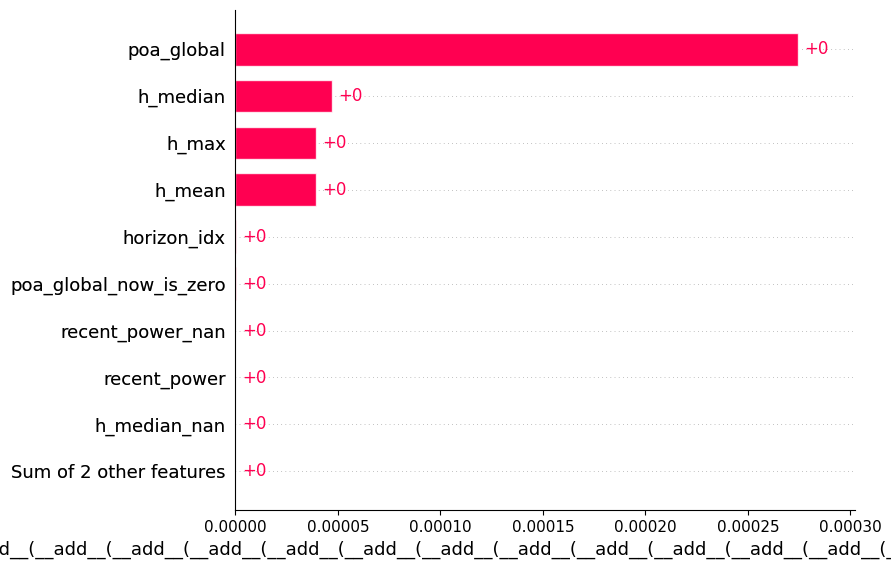

None

exc_t_nwpT_excF


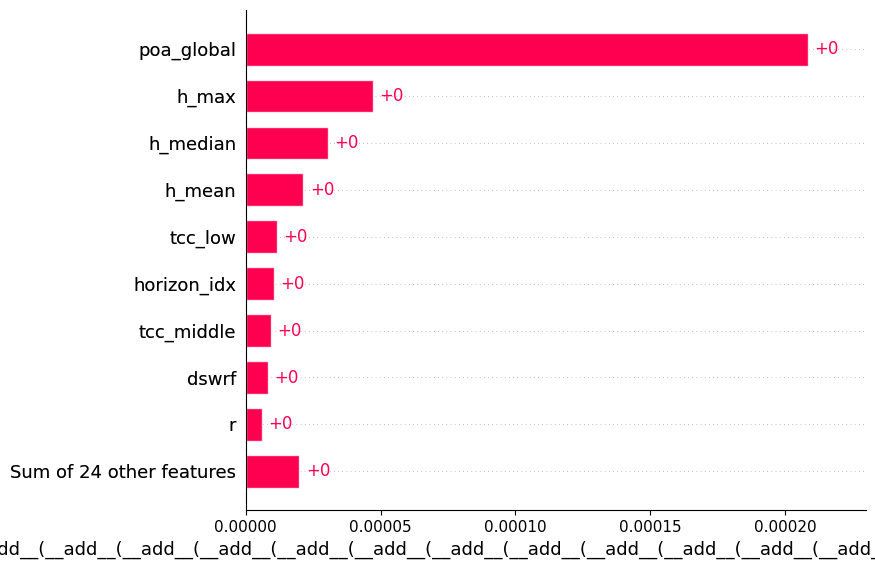

None

exc_t_nwpF_excT


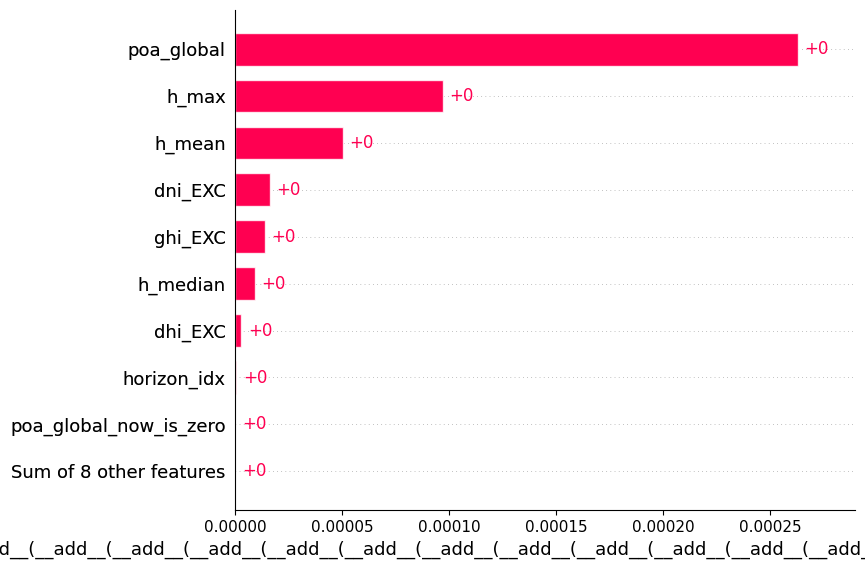

None

exc_t_nwpT_excT


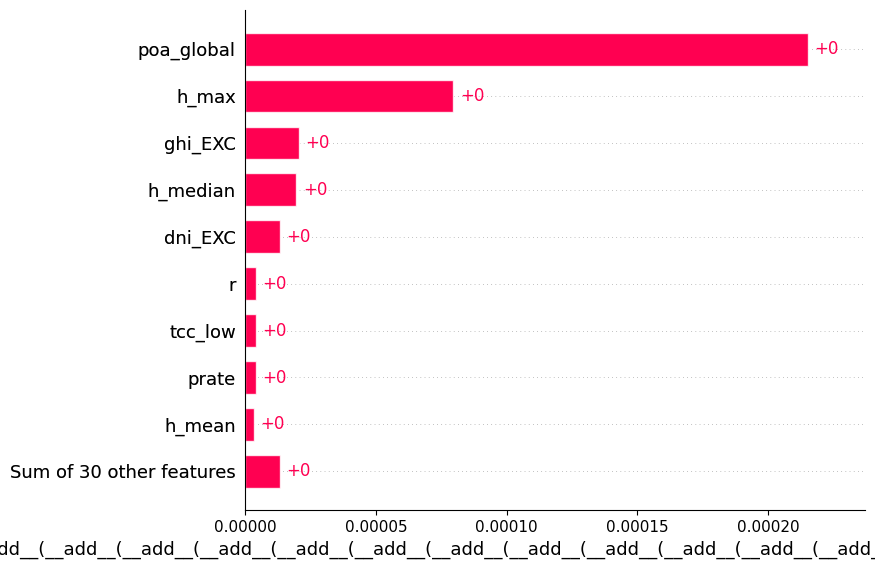

None

In [37]:
xs = [X(pv_id=row["pv_id"], ts=row["ts"]) for _, row in testset.sample(20).iterrows()]

for model_name, model in models.items():
    print(model_name)
    try:
        explanations = [model.explain(x) for x in xs]
    except Exception:
        continue
    explanation = sum(explanations) / len(explanations)

    display(shap.plots.bar(explanation))